In [1]:
! pip install pyprind
! pip install transformers

     |████████████████████████████████| 2.6 MB 7.7 MB/s 
     |████████████████████████████████| 636 kB 71.6 MB/s 
     |████████████████████████████████| 3.3 MB 66.5 MB/s 
     |████████████████████████████████| 895 kB 64.4 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [2]:
from transformers import BertTokenizer, TFBertForSequenceClassification, BertConfig
from transformers import InputExample, InputFeatures

config = BertConfig.from_pretrained("bert-base-uncased", hidden_dropout_prob=0.5, num_labels=2)
model = TFBertForSequenceClassification.from_pretrained("bert-base-uncased", config=config)
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model.summary()

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bert (TFBertMainLayer)       multiple                  109482240 
_________________________________________________________________
dropout_37 (Dropout)         multiple                  0         
_________________________________________________________________
classifier (Dense)           multiple                  1538      
Total params: 109,483,778
Trainable params: 109,483,778
Non-trainable params: 0
_________________________________________________________________


In [3]:
import tensorflow as tf
import pandas as pd
URL = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

dataset = tf.keras.utils.get_file(fname="aclImdb_v1.tar.gz", 
                                  origin=URL,
                                  untar=True,
                                  cache_dir='.',
                                  cache_subdir='')

84131840/84125825 [==============================] - 1s 0us/step


In [4]:
import pyprind
import pandas as pd
import os


#change the 'basepath' to the directory of the unzipped movie dataset
basepath = 'aclImdb'

labels = {'pos': 1, 'neg': 0}
pbar = pyprind.ProgBar(50000)
df = pd.DataFrame()
for s in ('test', 'train'):
    for l in ('pos', 'neg'):
        path = os.path.join(basepath, s, l)
        for file in sorted(os.listdir(path)):
            with open(os.path.join(path, file), 'r', encoding='utf-8') as infile:
                txt = infile.read()
            df = df.append([[txt, labels[l]]], ignore_index = True)
            pbar.update()

df.columns = ['DATA_COLUMN', 'LABEL_COLUMN']

import numpy as np

np.random.seed(0)
df = df.reindex(np.random.permutation(df.index))
df.to_csv('movie_data.csv', index = False, encoding='utf-8')

df = pd.read_csv('movie_data.csv', encoding='utf-8')
print('Shape of data frame : ', df.shape)
df.head(5)

0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:01:18


Shape of data frame :  (50000, 2)


,DATA_COLUMN,LABEL_COLUMN
0,"In 1974, the teenager Martha Moxley (Maggie Gr...",1
1,OK... so... I really like Kris Kristofferson a...,0
2,"***SPOILER*** Do not read this, if you think a...",0
3,hi for all the people who have seen this wonde...,1
4,"I recently bought the DVD, forgetting just how...",0


In [5]:
df.isnull().sum()

DATA_COLUMN     0
LABEL_COLUMN    0
dtype: int64

In [6]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size = 0.2, shuffle=True)
train, val = train_test_split(train, test_size = 0.2, shuffle = True)

print('train shape: \n',train.shape,'\ntest shape: \n', test.shape,'\nvalidation shape: \n', val.shape)
#print(train.shape[0]+val.shape[0]+test.shape[0]==df.shape[0])

train shape: 
 (32000, 2) 
test shape: 
 (10000, 2) 
validation shape: 
 (8000, 2)


In [7]:
def convert_data_to_examples(train, test, val, DATA_COLUMN, LABEL_COLUMN): 
  train_InputExamples = train.apply(lambda x: InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this case
                                                          text_a = x[DATA_COLUMN], 
                                                          text_b = None,
                                                          label = x[LABEL_COLUMN]), axis = 1)

  validation_InputExamples = val.apply(lambda x: InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this case
                                                          text_a = x[DATA_COLUMN], 
                                                          text_b = None,
                                                          label = x[LABEL_COLUMN]), axis = 1)
  

  test_InputExamples = test.apply(lambda x: InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this case
                                                          text_a = x[DATA_COLUMN], 
                                                          text_b = None,
                                                          label = x[LABEL_COLUMN]), axis = 1)
  

  return train_InputExamples, test_InputExamples, validation_InputExamples

  train_InputExamples, test_InputExamples, validation_InputExamples = convert_data_to_examples(train, 
                                                                           test,
                                                                            val, 
                                                                           'DATA_COLUMN', 
                                                                           'LABEL_COLUMN')
  
def convert_examples_to_tf_dataset(examples, tokenizer, max_length=128):
    features = [] # -> will hold InputFeatures to be converted later

    for e in examples:
        # Documentation is really strong for this method, so please take a look at it
        input_dict = tokenizer.encode_plus(
            e.text_a,
            add_special_tokens=True,
            max_length=max_length, # truncates if len(s) > max_length
            return_token_type_ids=True,
            return_attention_mask=True,
            pad_to_max_length=True, # pads to the right by default # CHECK THIS for pad_to_max_length
            truncation=True
        )

        input_ids, token_type_ids, attention_mask = (input_dict["input_ids"],
            input_dict["token_type_ids"], input_dict['attention_mask'])

        features.append(
            InputFeatures(
                input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids, label=e.label
            )
        )

    def gen():
        for f in features:
            yield (
                {
                    "input_ids": f.input_ids,
                    "attention_mask": f.attention_mask,
                    "token_type_ids": f.token_type_ids,
                },
                f.label,
            )

    return tf.data.Dataset.from_generator(
        gen,
        ({"input_ids": tf.int32, "attention_mask": tf.int32, "token_type_ids": tf.int32}, tf.int64),
        (
            {
                "input_ids": tf.TensorShape([None]),
                "attention_mask": tf.TensorShape([None]),
                "token_type_ids": tf.TensorShape([None]),
            },
            tf.TensorShape([]),
        ),
    )


DATA_COLUMN = 'DATA_COLUMN'
LABEL_COLUMN = 'LABEL_COLUMN'

In [8]:
train_InputExamples, test_InputExamples, validation_InputExamples = convert_data_to_examples(train, test, val, DATA_COLUMN, LABEL_COLUMN)

train_data = convert_examples_to_tf_dataset(list(train_InputExamples), tokenizer)
train_data = train_data.shuffle(100).batch(32).repeat(2)

validation_data = convert_examples_to_tf_dataset(list(validation_InputExamples), tokenizer)
validation_data = validation_data.batch(32)

test_data = convert_examples_to_tf_dataset(list(test_InputExamples), tokenizer)
test_data = test_data.batch(32)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2190: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [9]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import models

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=3e-5, epsilon=1e-08,
                                                 clipnorm=1.0), 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy('accuracy')])

#checkpoint_filepath = 'best_cobic_att.h5'
#checkpoint = ModelCheckpoint(checkpoint_filepath,monitor='val_loss', 
#                mode='min', verbose=1, save_best_only=True)

history_1 = model.fit(train_data, epochs=3, validation_data=validation_data)

Epoch 1/3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autogr

In [10]:
test_results = model.evaluate(test_data)
print("Test ACCURACY: {:.2f}%".format(test_results[1]*100))

313/313 [==============================] - 91s 291ms/step - loss: 0.4274 - accuracy: 0.8799
Test ACCURACY: 87.99%


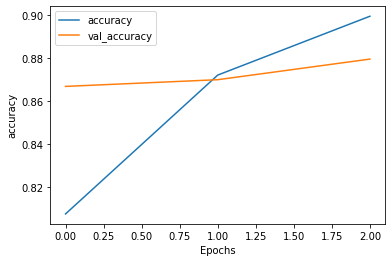

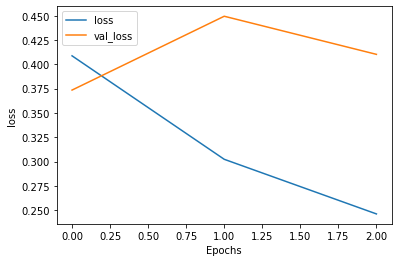

In [11]:
from matplotlib import pyplot as plt
def plot_graphs(history_1, string):
    plt.plot(history_1.history[string])
    plt.plot(history_1.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()
  
plot_graphs(history_1, "accuracy")
plot_graphs(history_1, "loss")